In [13]:
# Model Training & Testing
# CELL 1: Install Libraries
!pip install xgboost scikit-learn imbalanced-learn joblib numpy pandas matplotlib seaborn

In [14]:
# CELL 2: Import Libraries and Load your CSV file
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("/content/salary_prediction_data-Training.csv")

In [15]:
data

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,High School,8,Urban,Manager,63,Male,84620.053665
1,PhD,11,Suburban,Director,59,Male,142591.255894
2,Bachelor,28,Suburban,Manager,61,Female,97800.255404
3,High School,29,Rural,Director,45,Male,96834.671282
4,PhD,25,Urban,Analyst,26,Female,132157.786175
...,...,...,...,...,...,...,...
995,High School,8,Suburban,Analyst,25,Female,64683.389864
996,High School,24,Urban,Engineer,30,Female,74468.205020
997,Master,18,Rural,Analyst,44,Male,98207.026024
998,Bachelor,27,Suburban,Director,31,Female,108544.922720


In [16]:
# CELL 3 : Preprocessing

print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

# Display basic info
print("\n Dataset Overview:")
print(data.info())
print("\n Statistical Summary:")
print(data.describe())

# Check for missing values
print("\n Missing Values:")
print(data.isnull().sum())


Shape: (1000, 7)
Columns: ['Education', 'Experience', 'Location', 'Job_Title', 'Age', 'Gender', 'Salary']

 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Education   1000 non-null   object 
 1   Experience  1000 non-null   int64  
 2   Location    1000 non-null   object 
 3   Job_Title   1000 non-null   object 
 4   Age         1000 non-null   int64  
 5   Gender      1000 non-null   object 
 6   Salary      1000 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB
None

 Statistical Summary:
        Experience          Age         Salary
count  1000.000000  1000.000000    1000.000000
mean     14.771000    42.377000  105558.404239
std       8.341111    13.609412   28256.972075
min       1.000000    20.000000   33510.510669
25%       7.000000    30.000000   85032.141517
50%      15.000000    43.00

In [25]:
# CELL 4: FEATURE ENGINEERING
data['Experience_Group'] = pd.cut(data['Experience'], [0, 5, 15, 30, 100], labels=['Early_Career', 'Mid_Career', 'Late_Career', 'Expert'])
data['Early_Career'] = (data['Experience_Group'] == 'Early_Career').astype(int)
data['Mid_Career'] = (data['Experience_Group'] == 'Mid_Career').astype(int)
data['Late_Career'] = (data['Experience_Group'] == 'Late_Career').astype(int)

# Polynomial/Derived features
data['Experience_Sq'] = data['Experience'] ** 2
data['Experience_Per_Age'] = data['Experience'] / (data['Age'] + 1e-4)

# Manager or Director (example logic!)
data['Manager_Director'] = data['Job_Title'].isin(['Manager', 'Director']).astype(int)

# Interactions
data['HighExp_LowEdu'] = ((data['Experience'] > 15) & (data['Education'] == 'High School')).astype(int)
data['LowExp_HighEdu'] = ((data['Experience'] < 5) & (data['Education'].isin(['PhD', 'Master']))).astype(int)
data['Education_Job_Interaction'] = data['Education'] + '_' + data['Job_Title']
data['PhD_Experience'] = ((data['Education'] == 'PhD') & (data['Experience'] > 10)).astype(int)

data


,Education,Experience,Location,Job_Title,Age,Gender,Salary,Experience_Group,Early_Career,Mid_Career,Late_Career,Experience_Sq,Experience_Per_Age,Manager_Director,HighExp_LowEdu,LowExp_HighEdu,Education_Job_Interaction,PhD_Experience
0,High School,8,Urban,Manager,63,Male,84620.053665,Mid_Career,0,1,0,64,0.126984,1,0,0,High School_Manager,0
1,PhD,11,Suburban,Director,59,Male,142591.255894,Mid_Career,0,1,0,121,0.186440,1,0,0,PhD_Director,1
2,Bachelor,28,Suburban,Manager,61,Female,97800.255404,Late_Career,0,0,1,784,0.459016,1,0,0,Bachelor_Manager,0
3,High School,29,Rural,Director,45,Male,96834.671282,Late_Career,0,0,1,841,0.644443,1,1,0,High School_Director,0
4,PhD,25,Urban,Analyst,26,Female,132157.786175,Late_Career,0,0,1,625,0.961535,0,0,0,PhD_Analyst,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,High School,8,Suburban,Analyst,25,Female,64683.389864,Mid_Career,0,1,0,64,0.319999,0,0,0,High School_Analyst,0
996,High School,24,Urban,Engineer,30,Female,74468.205020,Late_Career,0,0,1,576,0.799997,0,1,0,High School_Engineer,0
997,Master,18,Rural,Analyst,44,Male,98207.026024,Late_Career,0,0,1,324,0.409090,0,0,0,Master_Analyst,0
998,Bachelor,27,Suburban,Director,31,Female,108544.922720,Late_Career,0,0,1,729,0.870965,1,0,0,Bachelor_Director,0


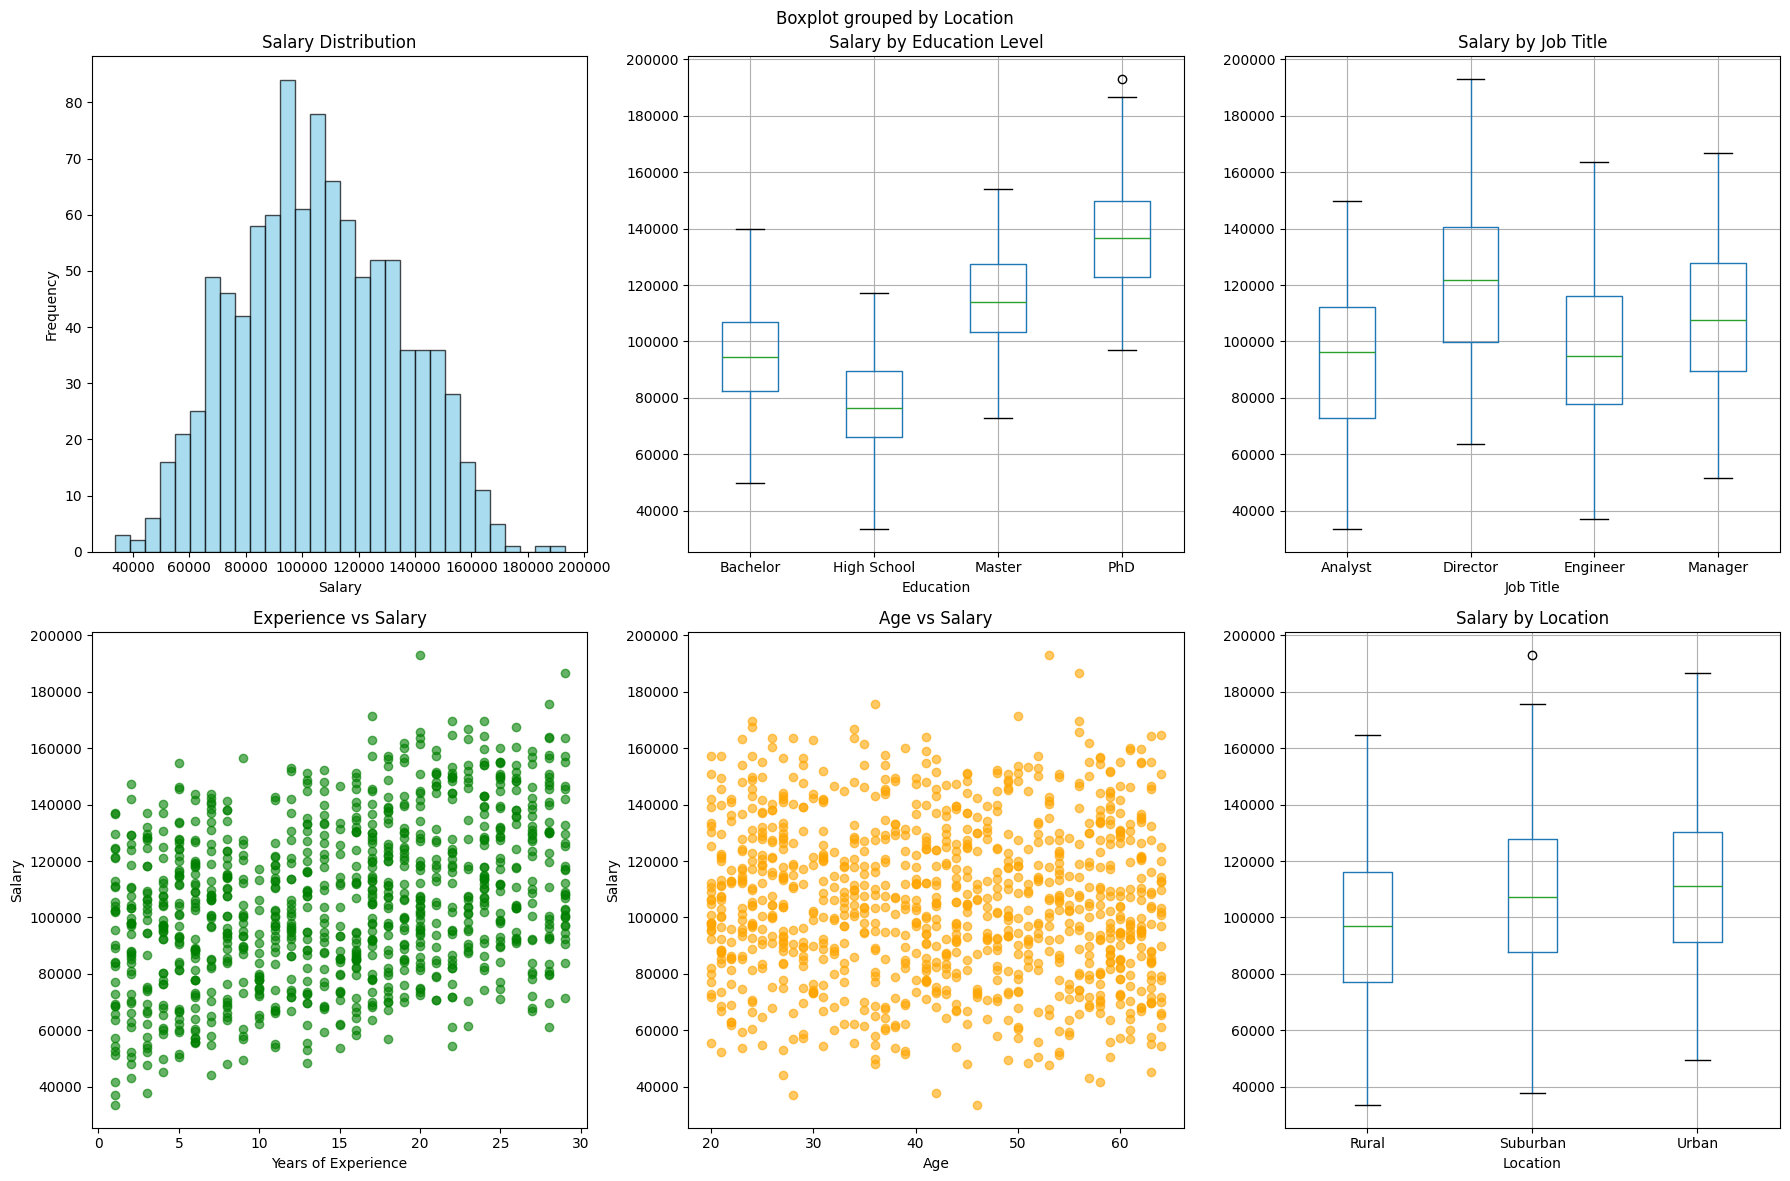

Value counts for categorical variables:

Education:
Education
High School    255
Bachelor       253
PhD            251
Master         241
Name: count, dtype: int64

Location:
Location
Suburban    345
Rural       345
Urban       310
Name: count, dtype: int64

Job_Title:
Job_Title
Director    275
Analyst     255
Manager     241
Engineer    229
Name: count, dtype: int64

Gender:
Gender
Male      516
Female    484
Name: count, dtype: int64


In [18]:
# CELL 5:EXPLORATORY DATA ANALYSIS


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Salary Distribution Analysis', fontsize=16, fontweight='bold')

# Salary distribution
axes[0,0].hist(data['Salary'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Salary Distribution')
axes[0,0].set_xlabel('Salary')
axes[0,0].set_ylabel('Frequency')

# Education vs Salary
data.boxplot(column='Salary', by='Education', ax=axes[0,1])
axes[0,1].set_title('Salary by Education Level')
axes[0,1].set_xlabel('Education')

# Job Title vs Salary
data.boxplot(column='Salary', by='Job_Title', ax=axes[0,2])
axes[0,2].set_title('Salary by Job Title')
axes[0,2].set_xlabel('Job Title')

# Experience vs Salary
axes[1,0].scatter(data['Experience'], data['Salary'], alpha=0.6, color='green')
axes[1,0].set_title('Experience vs Salary')
axes[1,0].set_xlabel('Years of Experience')
axes[1,0].set_ylabel('Salary')

# Age vs Salary
axes[1,1].scatter(data['Age'], data['Salary'], alpha=0.6, color='orange')
axes[1,1].set_title('Age vs Salary')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Salary')

# Location vs Salary
data.boxplot(column='Salary', by='Location', ax=axes[1,2])
axes[1,2].set_title('Salary by Location')
axes[1,2].set_xlabel('Location')

plt.tight_layout()
plt.show()

# Correlation matrix for numerical features
numerical_cols = ['Experience', 'Age', 'Salary']
correlation_matrix = data[numerical_cols].corr()



print("Value counts for categorical variables:")
for col in ['Education', 'Location', 'Job_Title', 'Gender']:
    print(f"\n{col}:")
    print(data[col].value_counts())


In [26]:
# CELL 6:DATA PREPROCESSING

# Define features and target
features = ["Education", "Experience", "Location", "Job_Title", "Age", "Gender","Experience_Group","Early_Career","Mid_Career","Late_Career","Experience_Sq","Experience_Per_Age",
            "Manager_Director","HighExp_LowEdu","LowExp_HighEdu","Education_Job_Interaction","PhD_Experience"]
target = "Salary"

X = data[features].copy()
y = data[target].copy()

print(f"Features: {features}")
print(f"Target: {target}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Create preprocessing pipelines
categorical_features = ["Education", "Location", "Job_Title", "Gender","Experience_Group","Early_Career","Mid_Career","Late_Career",
                        "Education_Job_Interaction"]
numerical_features = ["Experience", "Age","Experience_Sq","Experience_Per_Age","Manager_Director",
                      "HighExp_LowEdu","LowExp_HighEdu","PhD_Experience"]

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


Features: ['Education', 'Experience', 'Location', 'Job_Title', 'Age', 'Gender', 'Experience_Group', 'Early_Career', 'Mid_Career', 'Late_Career', 'Experience_Sq', 'Experience_Per_Age', 'Manager_Director', 'HighExp_LowEdu', 'LowExp_HighEdu', 'Education_Job_Interaction', 'PhD_Experience']
Target: Salary
Feature matrix shape: (1000, 17)
Target vector shape: (1000,)
Numerical features: ['Experience', 'Age', 'Experience_Sq', 'Experience_Per_Age', 'Manager_Director', 'HighExp_LowEdu', 'LowExp_HighEdu', 'PhD_Experience']
Categorical features: ['Education', 'Location', 'Job_Title', 'Gender', 'Experience_Group', 'Early_Career', 'Mid_Career', 'Late_Career', 'Education_Job_Interaction']


In [27]:
# CELL 7: MODEL TRAINING AND OPTIMIZATION
from sklearn.neighbors import KNeighborsRegressor

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Education']
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Create KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 15, 20, 25],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan']
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

print(" Hyperparameter tuning completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.2f}")

# Get the best model
best_model = grid_search.best_estimator_


Training set size: (800, 17)
Test set size: (200, 17)
Fitting 5 folds for each of 32 candidates, totalling 160 fits
 Hyperparameter tuning completed!
Best parameters: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 9, 'regressor__weights': 'distance'}
Best cross-validation score: 9421.37


 Model Performance Metrics:
Training MAE:   $10.04
Test MAE:       $9,264.82
Training RMSE:  $200.73
Test RMSE:      $11,751.94
Training R²:    0.9999
Test R²:        0.8293


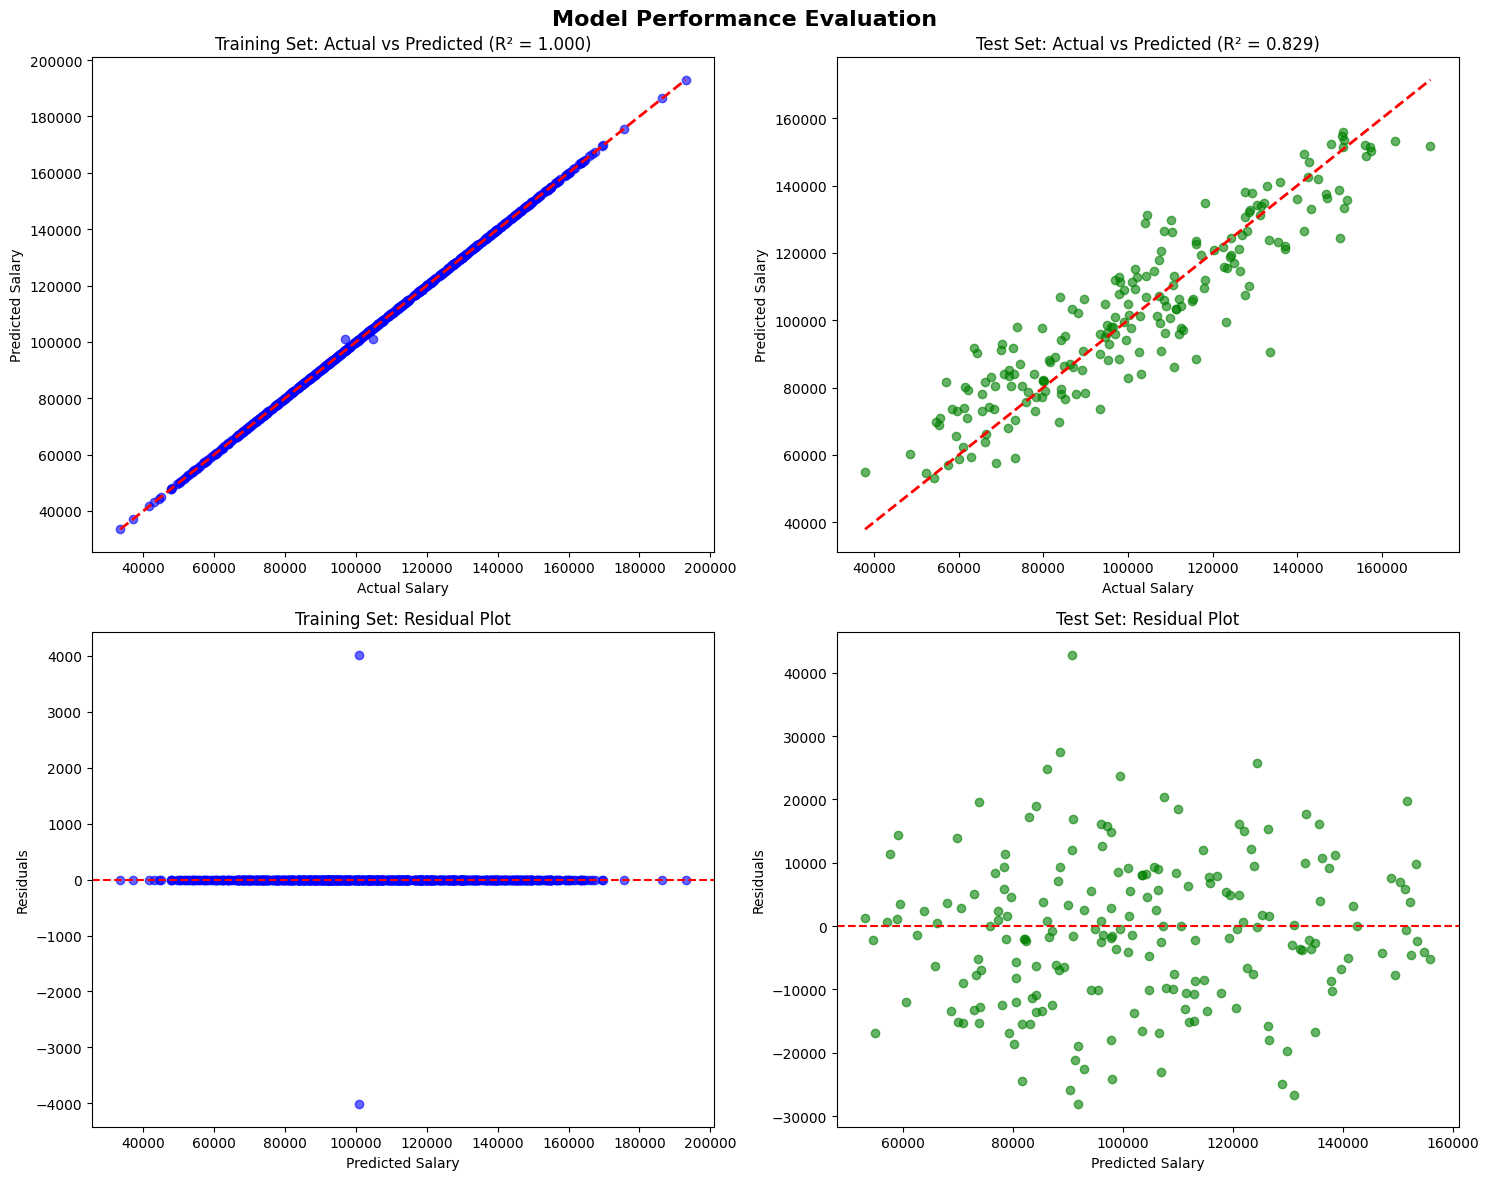

In [28]:
# CELL 8: MODEL EVALUATION

from sklearn.metrics import mean_squared_error

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(" Model Performance Metrics:")
print("=" * 40)
print(f"Training MAE:   ${train_mae:,.2f}")
print(f"Test MAE:       ${test_mae:,.2f}")
print(f"Training RMSE:  ${train_rmse:,.2f}")
print(f"Test RMSE:      ${test_rmse:,.2f}")
print(f"Training R²:    {train_r2:.4f}")
print(f"Test R²:        {test_r2:.4f}")

# Create evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Evaluation', fontsize=16, fontweight='bold')

# Actual vs Predicted (Training)
axes[0,0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Salary')
axes[0,0].set_ylabel('Predicted Salary')
axes[0,0].set_title(f'Training Set: Actual vs Predicted (R² = {train_r2:.3f})')

# Actual vs Predicted (Test)
axes[0,1].scatter(y_test, y_test_pred, alpha=0.6, color='green')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Salary')
axes[0,1].set_ylabel('Predicted Salary')
axes[0,1].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.3f})')

# Residuals (Training)
train_residuals = y_train - y_train_pred
axes[1,0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Salary')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Training Set: Residual Plot')

# Residuals (Test)
test_residuals = y_test - y_test_pred
axes[1,1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green')
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Salary')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Test Set: Residual Plot')

plt.tight_layout()
plt.show()


In [30]:
# CELL 9:SAVING THE MODEL

model_filename = "salary_predictor_final.pkl"
joblib.dump(best_model, model_filename)

print(f" Model saved as '{model_filename}'")
print("This model is now compatible with your backend.py script!")

# Verify the model can be loaded
try:
    loaded_model = joblib.load(model_filename)
    print(" Model loading verification successful!")

    # Test prediction with a sample
    sample_data = X_test.iloc[0:1]
    prediction = loaded_model.predict(sample_data)
    actual = y_test.iloc[0]

    print(f"\n Test Prediction:")
    print(f"Sample features: {sample_data.iloc[0].to_dict()}")
    print(f"Predicted salary: ${prediction[0]:,.2f}")
    print(f"Actual salary: ${actual:,.2f}")
    print(f"Difference: ${abs(prediction[0] - actual):,.2f}")

except Exception as e:
    print(f" Error loading model: {e}")


 Model saved as 'salary_predictor_final.pkl'
This model is now compatible with your backend.py script!
 Model loading verification successful!

 Test Prediction:
Sample features: {'Education': 'Master', 'Experience': 7, 'Location': 'Suburban', 'Job_Title': 'Analyst', 'Age': 56, 'Gender': 'Male', 'Experience_Group': 'Mid_Career', 'Early_Career': 0, 'Mid_Career': 1, 'Late_Career': 0, 'Experience_Sq': 49, 'Experience_Per_Age': 0.12499977678611288, 'Manager_Director': 0, 'HighExp_LowEdu': 0, 'LowExp_HighEdu': 0, 'Education_Job_Interaction': 'Master_Analyst', 'PhD_Experience': 0}
Predicted salary: $90,946.06
Actual salary: $107,847.48
Difference: $16,901.41


In [31]:

# CELL 10:MODEL USAGE EXAMPLES

print("🔮 Model Usage Examples:")
print("=" * 30)


def predict_salary_example(education, experience, location, job_title, age, gender):

    # Create input DataFrame
    input_data = pd.DataFrame({
        'Education': [education],
        'Experience': [experience],
        'Location': [location],
        'Job_Title': [job_title],
        'Age': [age],
        'Gender': [gender]
    })

    # Make prediction
    prediction = loaded_model.predict(input_data)
    return prediction[0]

# Example predictions
examples = [
    ("PhD", 5, "Urban", "Director", 35, "Female"),
    ("Bachelor", 10, "Suburban", "Manager", 40, "Male"),
    ("Master", 15, "Rural", "Analyst", 45, "Female"),
    ("High School", 20, "Urban", "Engineer", 50, "Male")
]

print(" Sample Predictions:")
for i, (edu, exp, loc, job, age, gender) in enumerate(examples, 1):
    predicted_salary = predict_salary_example(edu, exp, loc, job, age, gender)
    print(f"\nExample {i}:")
    print(f"  Profile: {edu}, {exp} years exp, {loc}, {job}, {age} years old, {gender}")
    print(f"  Predicted Salary: ${predicted_salary:,.2f}")

# Feature importance analysis
print("\n Model Analysis:")


# Get feature names after preprocessing
feature_names = (
    numerical_features +
    list(best_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

print(f"Total features after preprocessing: {len(feature_names)}")
print("Feature names:", feature_names[:10], "... (showing first 10)")


🔮 Model Usage Examples:
 Sample Predictions:


ValueError: columns are missing: {'PhD_Experience', 'Experience_Sq', 'Experience_Group', 'HighExp_LowEdu', 'Mid_Career', 'Late_Career', 'Manager_Director', 'LowExp_HighEdu', 'Education_Job_Interaction', 'Experience_Per_Age', 'Early_Career'}